# Lab 6. RNN
### Importy

In [0]:
%matplotlib inline

# imports 
import torch
from torch import nn
from torch.nn.functional import cross_entropy

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import numpy as np
import matplotlib.pyplot as plt 
from typing import Tuple, Optional

### Ładowanie danych
Na tych zajęciach będziemy traktować cyfry z MNISTa jako dane sekwencyjne, gdzie w danym kroku czasowym $T$ obserwujemy $T$-ty wiersz pikseli z cyfry.

In [0]:
transforms = Compose([ToTensor(), Lambda(lambda x: x.reshape(28, 28))])

train_data = MNIST(root='.', train=True, transform=transforms, download=True)
test_data = MNIST(root='.', train=False, transform=transforms)

## Zadanie 1.

Zaimplementuj "zwykłą" sieć rekurencyjną. 
![rnn](utils/rnn.png)

* W klasie `RNN` należy zainicjalizować potrzebne wagi oraz zaimplementować główną logikę dla pojedynczej chwili czasowej $x_t$
* Wyjście z sieci możemy mieć dowolny rozmiar, potrzebna jest również warstwa przekształcająca stan ukryty na wyjście.
* W pętli uczenia należy dodać odpowiednie wywołanie sieci. HINT: pamiętać o iterowaniu po wymiarze "czasowym".


In [0]:
class RNN(nn.Module):
    
    def __init__(self, 
                 input_size: int,
                 hidden_size: int, 
                 output_size: int):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.input_to_hidden = torch.nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_to_output = torch.nn.Linear(hidden_size, output_size)
        self.tanh = torch.nn.Tanh()
    
    def forward(self, 
                input: torch.tensor, 
                hidden: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:

        hidden = torch.tanh(self.input_to_hidden(input) + self.hidden_to_hidden(hidden))
        hidden.retain_grad()
        output = self.hidden_to_output(hidden)
        
        return output, hidden
    
    def init_hidden(self, batch_size: int) -> torch.Tensor:
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

### Pętla uczenia

In [94]:
torch.manual_seed(1337)

batch_size = 50

# build data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# initialize network and optimizer
rnn = RNN(28, 64, 10)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)   

# we will train for only a single epoch 
epochs = 1

# main loop
for epoch in range(epochs):    
    grads = []
    for i, (x, y) in enumerate(train_loader):  
        optimizer.zero_grad()
        # get initial hidden state
        hidden = rnn.init_hidden(x.shape[0])
        
        # get output for the sample, remember that we treat it as a sequence
        # so you need to iterate over the 2nd, time dimensiotn
        
        hiddens = []
        seq_len = x.shape[1]
        for t in range(seq_len):
            output, hidden = rnn(x[:,t,:], hidden)
            hiddens.append(hidden)

        loss = cross_entropy(output, y)
        loss.backward()
        optimizer.step()  
        
        grads.append([np.linalg.norm(h.grad.numpy()) for h in hiddens])
        
        if i % 100 == 1:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss}")

np_grads = np.array([np.array(xi) for xi in grads])
# evaluate on the test set
with torch.no_grad():
    
    correct = 0
    for i, (x, y) in enumerate(test_loader):

        hidden = rnn.init_hidden(x.shape[0])
        seq_len = x.shape[1]
        
        for t in range(seq_len):
            output, hidden = rnn(x[:, t, :], hidden)

        pred = output.argmax(dim=1)
        correct += int(sum(pred == y))
    
    accuracy = correct / (batch_size * len(test_loader))

    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.4, "Subject to random seed you should get over 0.4 accuracy, try changing the seed!"

Epoch: 0 Iter: 1/1200 Loss: 2.325571060180664
Epoch: 0 Iter: 101/1200 Loss: 1.614290714263916
Epoch: 0 Iter: 201/1200 Loss: 1.0623154640197754
Epoch: 0 Iter: 301/1200 Loss: 0.9315030574798584
Epoch: 0 Iter: 401/1200 Loss: 0.8028134703636169
Epoch: 0 Iter: 501/1200 Loss: 0.9220730662345886
Epoch: 0 Iter: 601/1200 Loss: 0.9503166079521179
Epoch: 0 Iter: 701/1200 Loss: 0.7411617040634155
Epoch: 0 Iter: 801/1200 Loss: 1.2632415294647217
Epoch: 0 Iter: 901/1200 Loss: 1.1591308116912842
Epoch: 0 Iter: 1001/1200 Loss: 1.3274043798446655
Epoch: 0 Iter: 1101/1200 Loss: 1.457504153251648
Final Accuracy: 0.4464


## Zadanie 2
Dopisz kod do powyższej pętli, który zbiera gradienty po kolejnych stanach ukrytych dla przykładu. Pokaż (za pomocą wykresu numpy) efekt zanikającego gradientu rysując średnie normy gradientu dla każdego stanu ukrytego po każdym kroku. HINT: dla MNISTa mamy 28 kroków. 

**Ważne:** Ponieważ normalnie w torchu czyścimy wszystkie gradienty po każdej iteracji aby je zachować w dla niektórych wag przydatna będzie metoda [`retain_grad`](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.retain_grad).

<BarContainer object of 28 artists>

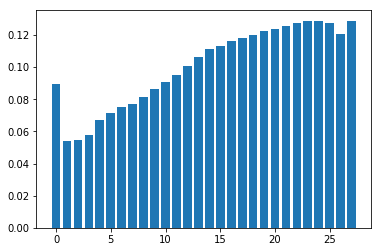

In [95]:
# mean_grads in assume to be a 1D array or list of average gradients norm per timestep memory 
np_grads = np.array([np.array(xi) for xi in grads])
mean_grads = np_grads.mean(0)

plt.bar(x=np.arange(len(mean_grads)), height=mean_grads)

## Zadanie 3
Ostatnim zadaniem jest implementacji komórki i sieci LSTM. 

![lstm](utils/lstm.png)

* W klasie `LSTMCell` ma znaleźć się główna loginka LSTMa, czyli wszystkie wagi do stanów `hidden` i `cell` jak i bramek kontrolujących te stany. 
* W klasie `LSTM` powinno znaleźć się wywołanie komórki LSTM, HINT: poprzednio było w pętli uczenia, teraz przeniesiemy to do klasy modelu.
* W pętli uczenia należy uzupełnić brakujące wywołania do uczenia i ewaluacji modelu.

Zdecydowanie polecam [materiały Chrisa Olaha](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) do zarówno zrozumienia jak i ściągi do wzorów.

Zadaniem jest osiągnięcie dokładności na poziomie przynajmniej 90%, przy prawidłowej implementacji nie powinno być z tym problemów używając podanych hiperparametrów. Dozwolona jest oczywiście zmienia `random seed`.

### Komórka LSTM

In [0]:
class LSTMCell(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTMCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        # initialize LSTM weights 
        # NOTE: there are different approaches that are all correct 
        # (e.g. single matrix for all input opperations), you can pick
        # whichever you like for this task
        
        self.input2hidden = torch.nn.Linear(input_size, hidden_size) 
        self.forget_gate = torch.nn.Linear(hidden_size, hidden_size)
        self.input_gate = torch.nn.Linear(hidden_size, hidden_size)
        self.memory_init = torch.nn.Linear(hidden_size, hidden_size)
        self.move_to_output = torch.nn.Linear(hidden_size, hidden_size)
        
    def forward(self, 
                input: torch.tensor, 
                states: Tuple[torch.tensor, torch.tensor]) -> Tuple[torch.tensor, torch.tensor]:
        
        hidden, cell = states
        
        # Compute input, forget, and output gates
        # then compute new cell state and hidden state
        # see http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
        combined = self.input2hidden(input) + hidden
        
        f_t = torch.sigmoid(self.forget_gate(combined))
        cell_prim = torch.tanh(self.memory_init(combined))
        i_t = torch.sigmoid(self.input_gate(combined))
        cell = f_t * cell + i_t * cell_prim
        
        o_t = torch.sigmoid(self.move_to_output(combined))
        hidden = o_t * torch.tanh(cell)
        
        return hidden, cell

### Klasa modelu LSTM

In [0]:
class LSTM(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = 10

        self.cell = LSTMCell(input_size=input_size, hidden_size=hidden_size)
        
        
    def forward(self, 
                input: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        :param input: torch.tensor 
            Input tesnor for a single observation at timestep t
            shape [batch_size, input_size]
        Returns Tuple of two torch.tensors, both of shape [seq_len, batch_size, hidden_size]
        """
        
        batch_size = input.shape[0]
        
        initial_states = self.init_hidden_cell(batch_size)
        
        hiddens = []
        cells = []
        
        hidden, cell = initial_states

        # this time we will process the whole sequence in the forward method
        # as oppose to the previous exercise, remember to loop over the timesteps
        
        seq_len = input.shape[1]
        
        for t in range(seq_len):
            hidden, cell = self.cell(input[:,t,:], (hidden, cell))
            hiddens.append(hidden)
            cells.append(cell)
        
        hiddens = torch.stack(hiddens)
        
        cells = torch.stack(cells)
        
        return hiddens, cells
    
    def init_hidden_cell(self, batch_size):
        """
        Returns initial value for the hidden and cell states
        """
        return (torch.zeros(batch_size, self.hidden_size, requires_grad=True), 
                torch.zeros(batch_size, self.hidden_size, requires_grad=True))

### Pętla uczenia

In [89]:
from itertools import chain

torch.manual_seed(1337)

batch_size = 50

# build data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# initialize the lstm with an additional cliassifier layer at the top
lstm = LSTM(input_size=28, hidden_size=64)
clf = nn.Linear(in_features=64, out_features=10)

# initialize a optimizer
params = chain(lstm.parameters(), clf.parameters())
optimizer = torch.optim.Adam(params, lr=0.01) 

# we will train for only a single epoch 
epoch = 1

# main loop
for epoch in range(epoch):
    
    for i, (x, y) in enumerate(train_loader):        
        
        optimizer.zero_grad()
        
        # get output for the sample, remember that we treat it as a sequence
        # so you need to iterate over the sequence length here
        hiddens, cells = lstm(x)
        outputs = clf(hiddens)
        output = outputs[-1]
        # calucate the loss
        loss = cross_entropy(output, y)
        loss.backward()
        optimizer.step()                                
        
        if i % 50 == 1:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss:.4f}")

# evaluate on the test set
with torch.no_grad():
    
    correct = 0
    for i, (x, y) in enumerate(test_loader):
        
        hiddens, cells = lstm(x)
        outputs = clf(hiddens)
        output = outputs[-1]
        
        pred = output.argmax(dim=1)
        correct += int(sum(pred == y))
    
    accuracy = correct / (batch_size * len(test_loader))
    
    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.9, "Subject to random seed you should get over 0.9 accuracy, try changing the seed!"

Epoch: 0 Iter: 1/1200 Loss: 2.3013
Epoch: 0 Iter: 51/1200 Loss: 1.1511
Epoch: 0 Iter: 101/1200 Loss: 0.7476
Epoch: 0 Iter: 151/1200 Loss: 0.7537
Epoch: 0 Iter: 201/1200 Loss: 0.8660
Epoch: 0 Iter: 251/1200 Loss: 0.5561
Epoch: 0 Iter: 301/1200 Loss: 0.3881
Epoch: 0 Iter: 351/1200 Loss: 0.7335
Epoch: 0 Iter: 401/1200 Loss: 0.3890
Epoch: 0 Iter: 451/1200 Loss: 0.4592
Epoch: 0 Iter: 501/1200 Loss: 0.5516
Epoch: 0 Iter: 551/1200 Loss: 0.1947
Epoch: 0 Iter: 601/1200 Loss: 0.3314
Epoch: 0 Iter: 651/1200 Loss: 0.4704
Epoch: 0 Iter: 701/1200 Loss: 0.1694
Epoch: 0 Iter: 751/1200 Loss: 0.2559
Epoch: 0 Iter: 801/1200 Loss: 0.2559
Epoch: 0 Iter: 851/1200 Loss: 0.1106
Epoch: 0 Iter: 901/1200 Loss: 0.3667
Epoch: 0 Iter: 951/1200 Loss: 0.2223
Epoch: 0 Iter: 1001/1200 Loss: 0.2610
Epoch: 0 Iter: 1051/1200 Loss: 0.1287
Epoch: 0 Iter: 1101/1200 Loss: 0.3183
Epoch: 0 Iter: 1151/1200 Loss: 0.1378
Final Accuracy: 0.9376
